# Bloqade

Bloqade is a [Julia Language](https://julialang.org/) package for quantum computation and quantum dynamics based on neutral-atom architectures.

Neutral-atom quantum computers have two major modes of computation: the first mode is a "digital mode" to do universal, digital quantum computation that uses two ground states $|0\rangle$ and $|1\rangle$ to encode the qubit, which has long coherence time, and one Rydberg state $|r\rangle$ to entangle the qubits; the second mode is an "analog mode" as a programmable quantum simulator that uses one ground state $|g\rangle$ and one Rydberg state $|r\rangle$, where the quantum dynamics is governed by a Rydberg Hamiltonian $\hat{\mathcal{H}}$ described below.

Currently, Bloqade enables the easy design and fast execution of quantum dynamics in the analog mode,  based on the neutral-atom quantum computing architecture. Besides fast full Hilbert-space simulation on CPUs, the main features include the design of arbitrary-layout quantum registers ([Lattices](https://queracomputing.github.io/Bloqade.jl/dev/lattices/#Lattices)), easy waveform generation ([Waveforms](https://queracomputing.github.io/Bloqade.jl/dev/waveform/#Waveforms)), simulation in subspace constrained by the Rydberg blockade ([Working with Subspace](https://queracomputing.github.io/Bloqade.jl/dev/subspace/#subspace)), faster GPU-accelerated simulation ([GPU Acceleration](https://queracomputing.github.io/Bloqade.jl/dev/cuda/#cuda)), and more.

<h2 style="color:#D30982;">qBraid Instructions</h2> 

To run this notebook, make sure you have launched the qBraid Bloqade Lab image, and have selected the `Julia 1.8.5` kernel in the top-right (see [switching kernels](https://docs.qbraid.com/en/latest/lab/notebooks.html#switch-notebook-kernel)).

## What does Bloqade Do?

In the analog mode, Bloqade simulates the time evolution of a quantum state under the Schrödinger equation where the Hamiltonian is the interacting Rydberg Hamiltonian $\hat{\mathcal{H}}$, 

$$i \hbar \dfrac{\partial}{\partial t} | \psi \rangle = \hat{\mathcal{H}}(t) | \psi \rangle,$$

$$ \frac{\mathcal{H}(t)}{\hbar} = \sum_j \frac{\Omega_j(t)}{2} \left( e^{i \phi_j(t) } | g_j \rangle  \langle r_j | + e^{-i \phi_j(t) } | r_j \rangle  \langle g_j | \right) - \sum_j \Delta_j(t) \hat{n}_j + \sum_{j < k} V_{jk} \hat{n}_j \hat{n}_k.$$

Following the atomic physics nomenclature, $\Omega_j$, $\phi_j$, and $\Delta_j$  denote the Rabi frequency, laser phase, and the detuning of the driving laser field on atom (qubit) $j$ coupling the two states  $| g_j \rangle $ (ground state) and $ | r_j \rangle $ (Rydberg state); $\hat{n}_j = |r_j\rangle \langle r_j|$ is the number operator, and $V_{jk} = C_6/|\mathbf{x}_j - \mathbf{x}_k|^6$ describes the Rydberg interaction (van der Waals interaction) between atoms $j$ and $k$ where $\mathbf{x}_j$ denotes the position of the atom $j$; $C_6$ is the Rydberg interaction constant that depends on the particular Rydberg state used. For Bloqade, the default $C_6 = 862690 \times 2\pi \text{ MHz μm}^6$ for $|r \rangle = \lvert 70S_{1/2} \rangle$ of the $^{87}$ Rb atoms; $\hbar$ is the reduced Planck's constant. Sometimes, we also refer the states $|g\rangle$ and $|r\rangle$ as $|0\rangle$ and $|1\rangle$ as well in the analog mode.

Starting from an initial quantum state $| \psi_{\text{ini}} \rangle$, Bloqade simulates its time evolution under the Hamiltonian $\hat{\mathcal{H}}(t)$, given the qubit positions and the time-dependent profiles for  $\Omega_j$, $\phi_j$, and $\Delta_j$. Bloqade then outputs the real-time-evolved state $| \psi(t) \rangle$, which can then be used for measuring different observables.

More specifically, here are the steps to program neutral-atom quantum computers using Bloqade:

- specify atom positions (see [Lattices](https://queracomputing.github.io/Bloqade.jl/dev/lattices/#Lattices))
- program waveforms of Hamiltonian parameters (see [Waveforms](https://queracomputing.github.io/Bloqade.jl/dev/waveform/#Waveforms))  
- create the Hamiltonian (see [Hamiltonians](https://queracomputing.github.io/Bloqade.jl/dev/hamiltonians/#Hamiltonians))
- specify the initial state (see [Registers and Observables](https://queracomputing.github.io/Bloqade.jl/dev/registers/#observables))
- emulation (see [Emulation](https://queracomputing.github.io/Bloqade.jl/dev/emulation/#emulation))
- measurements & observables (see [Registers and Observables](https://queracomputing.github.io/Bloqade.jl/dev/registers/#observables)).

The default units for various quantities are: 

|  Quantity  | Default Unit |
|----------- |------------- |
|   Length   |      μm      |
|    Time    |      μs      |
| $\Omega$   |    rad/μs    |
|  $\phi$    |     rad      |
| $\Delta$   |    rad/μs    |

You may often find $\Omega$ and $\Delta$ written in units of MHz. If you see something like “$\Omega$ is 4 MHz”, it means $\Omega = 2\pi \times 4$ MHz $= 25.13$ rad/μs. Using MHz also makes it very easy to understand the pulse time duration it takes to flip the atom from $|g\rangle$ to $|r\rangle$ (and vice versa), i.e., a π-pulse. For example, for a π-pulse which means $\Omega\,t = \pi$, if $\Omega = 2\pi \times 4$ MHz, then it takes $t = 0.125$ μs to do the π-pulse.

## A Simple Example

Let's try a simple example of simulating quantum many-body dynamics governed by the Rydberg Hamiltonian. 

We start by loading the Bloqade Module:

In [1]:
using Bloqade

As one can see from the Rydberg Hamiltonian, the interactions between Rydberg atoms depend on their positions. Bloqade provides several built-in [Lattices](https://queracomputing.github.io/Bloqade.jl/dev/lattices/#Lattices) structures for specifying the atom positions. For instance, we can use the following codes to quickly generate a chain of 10 atoms in 1D:

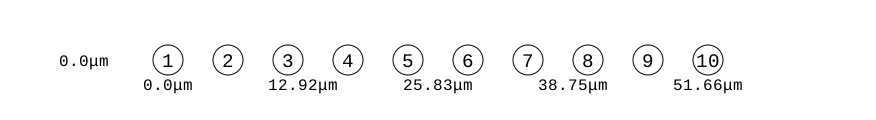

In [2]:
nsites = 10;
atoms = generate_sites(ChainLattice(), nsites, scale = 5.74)

We have set the distance between nearest-neighbor atoms to be 5.74 μm. Note that the default unit of length is μm as shown in the table above.

Let's set both $\Omega$ and $\Delta$ to be constants (and $\phi = 0$). Since all the variable parameters in the Hamiltonian are specified, we can now create an interacting Rydberg Hamiltonian by using [`rydberg_h`](@ref):

In [3]:
h = rydberg_h(atoms; Ω = 4 * 2π, Δ = 0)

nqubits: 10
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
├─ [+] 2π ⋅ 2.0 ⋅ ∑ σ^x_i
└─ [-] 2π ⋅ 0.0 ⋅ ∑ n_i


To create more complicated waveforms for $\Omega$ and $\Delta$ and find the supported utilities, please refer to the [Waveforms](@ref) page.

Let's create an initial state with all the atoms in the ground state by using [`zero_state`](@ref).

In [4]:
reg = zero_state(10)

ArrayReg{2, ComplexF64, Array...}
    active qubits: 10/10
    nlevel: 2

We are interested in measuring observables of the final quantum state of the Rydberg system starting from the initial state and evolving under the Rydberg Hamiltonian over some time duration. We can first create the problem and then directly simulate the time evolution.

In [5]:
prob = SchrodingerProblem(reg, 1.6, h)
integrator = init(prob, Vern8());
emulate!(prob);

Here, we have chosen the ODE-based solver (`Vern8()`) by using [`SchrodingerProblem`](@ref) and set the total evolution time to be 1.6 μs.

After simulating the time evolution and get the final state, we can measure the Rydberg population at each site for the final state:

In [6]:
rydberg_populations = map(1:nsites) do i
    rydberg_density(prob.reg, i)
end

10-element Vector{Float64}:
 0.4219218349500676
 0.17593447140372442
 0.28413947095247005
 0.2000010811933471
 0.30570483375391544
 0.3057048337539158
 0.20000108119334764
 0.2841394709524703
 0.1759344714037246
 0.42192183495006774

`prob.reg` is the register storing the final state after the time evolution.